In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit import pulse, transpile, schedule
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia
import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.pulse.library import Drag

### Dynamical Decoupling

Dynamical Decoupling is one of the earliest techquinique for error suppression, having been tested experimentally in many plataforms, such as NMR - G. A. Álvarez, A. Ajoy, X. Peng, and D. Suter, Performance comparison of dynamical decoupling sequences for a qubit in a rapidly fluctuating spin bath, Phys. Rev. A 82, 042306 (2010)- and is known to being able to enhance the accuracy of quantum algotithms. The use of Pulse can implement sequences of DD in a much better manner when compared to circuit-level implementation -because of the better control especially, with circuit operations research has found that because of the transpile() function, for ex., two equal circuits may perform different DD sequences.

In circuits, as we are going to see, we may have qubits who have a lot of a idle time after a certain operation and for the qubits this is bad and it may cause it to dephase.

In [2]:
from qiskit.visualization import plot_histogram

In [3]:
import qiskit

In [8]:
simulator = Aer.get_backend('aer_simulator_statevector')

In [4]:
backend = FakeValencia()

In [15]:
circuit = QuantumCircuit(4)
circuit.x(0)
circuit.cx(0,1)
circuit.cx(1,3)

circuit.measure_all()

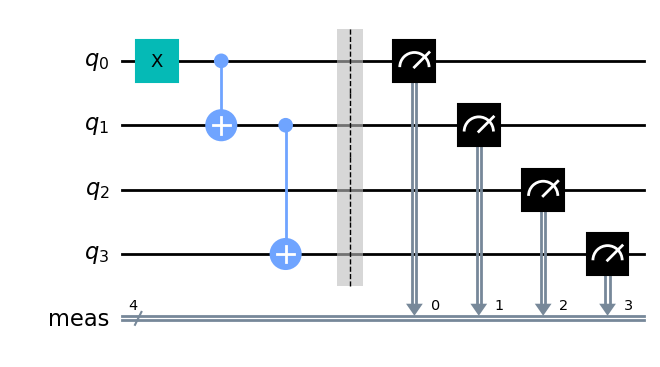

In [16]:
circuit.draw('mpl')

As we can see here there is a lot of idle time in each of these drives!

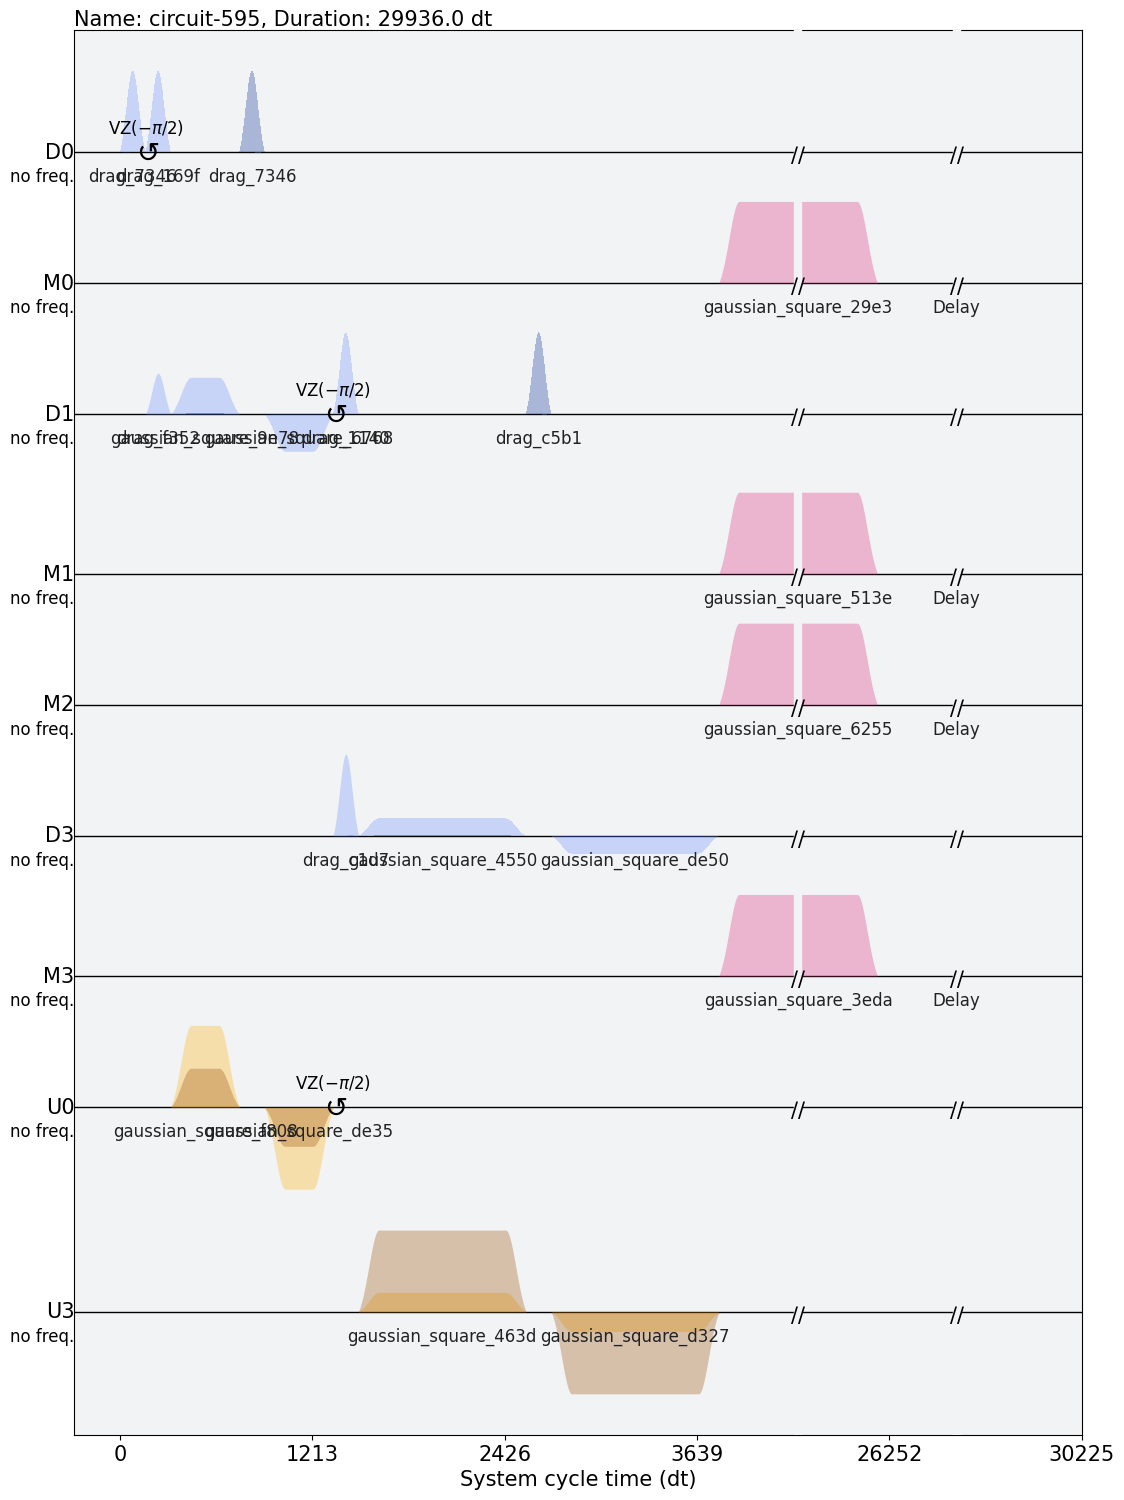

In [17]:

circuit_transp = transpile(circuit, backend)
circuit_sched = schedule(circuit, backend)
circuit_sched.draw()

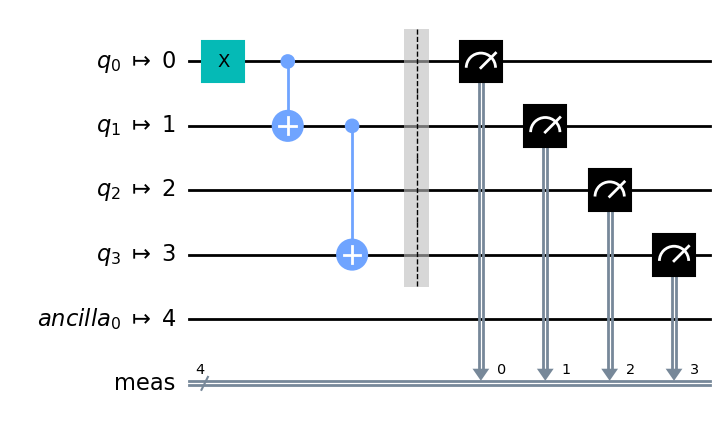

In [42]:
circuit_transp.draw('mpl')

In [25]:
number_of_shots = 2**11

In [26]:
simulated_job = simulator.run(transpile(circuit, simulator), shots = number_of_shots)
simulated_counts = simulated_job.result().get_counts()

In [27]:
backend_job=  backend.run(circuit_transp, shots = number_of_shots)
backend_counts = backend_job.result().get_counts()

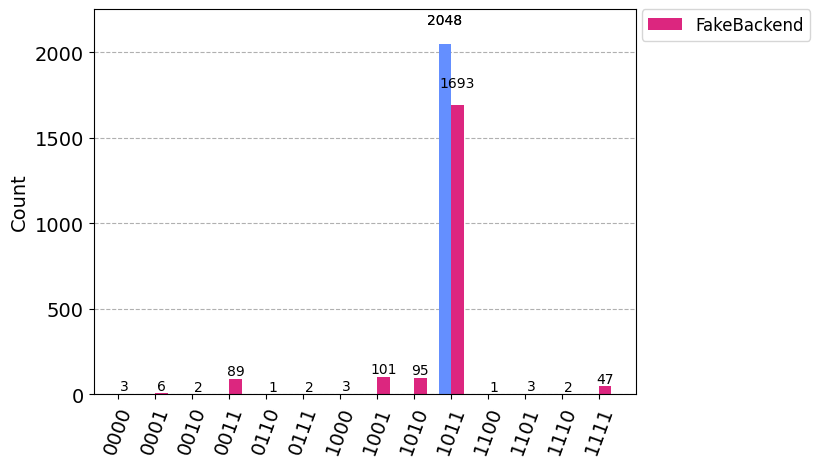

In [28]:
plot_histogram([simulated_counts, backend_counts], legend=['ideal', 'FakeBackend'])

Fake Backend has a bunch of errors, whereas simulator is perfect.

In [46]:
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer

durations = InstructionDurations(
            [("cx", [0,1], backend.properties().gate_length('cx', [0,1])/backend.configuration().dt),
            ("cx", [1,3], backend.properties().gate_length('cx', [1,3])/backend.configuration().dt),
            ('x', None,backend.properties().gate_length('x', 0)/backend.configuration().dt ),
            ]
)

print(durations)

x: 160.0 dt
cx(0, 1): 1183.9999999999998 dt
cx(1, 3): 2432.0 dt



In [41]:
back_prop = backend.configuration()
print("Configuration dictionary:", back_prop.to_dict())

Configuration dictionary: {'backend_name': 'fake_valencia', 'backend_version': '1.4.6', 'n_qubits': 5, 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'cx', 'parameters': [], 'qasm_def': 'gate cx q0, q1 { CX q0, q1; }', 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]}], 'local': False, 'simulator': False, 'conditional': False, 'open_pulse': True, 'memory': True, 'max_shots': 8192, 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], 

In [47]:
durations = InstructionDurations(
            [("cx", [0,1], 1184),('reset', None, 10), ('measure', None, 22400), ('y', None,160 ), ('cx', [1,3], 2432), ("x", None, 160) ])

The dynamic decoupling we are using is  4X where we put four X gates which will cancel out and make the circuit a lot less idle, making the results better! It is important to note that it is important to use proper DD sequences because pulse doesnt have perfect rotations so it may be detrimental to the circuit instead of mantaing coherence.

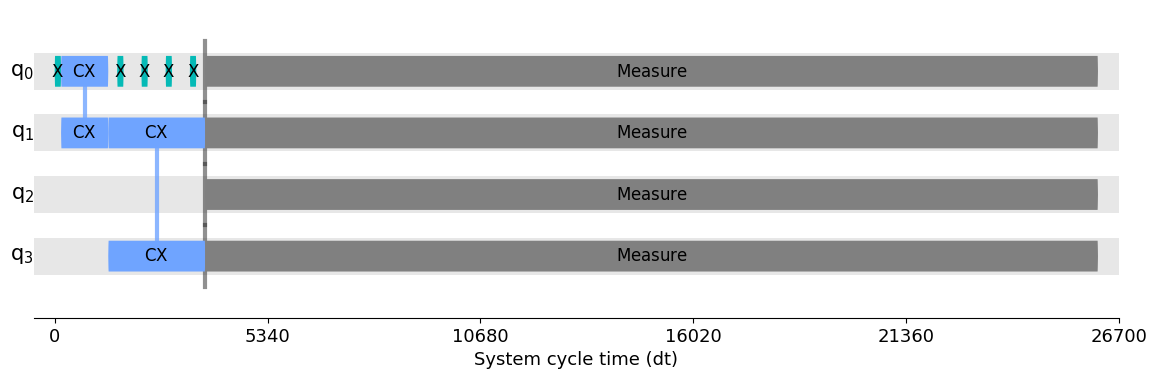

In [48]:
from qiskit.circuit.library import XGate, YGate

circ = QuantumCircuit(4)
circ.x(0)
circ.cx(0,1)
circ.cx(1,3)

circ.measure_all()

dd_sequence = [XGate(), XGate(), XGate(), XGate()]
passmanager = PassManager([ALAPSchedule(durations), 
                           DynamicalDecoupling(durations, dd_sequence)])
### The passmanager serves to better schedule and connect the gates and sequences we are using, so it is best for optimization
### of circuits
circ_dd = passmanager.run(circ)
timeline_drawer(circ_dd)

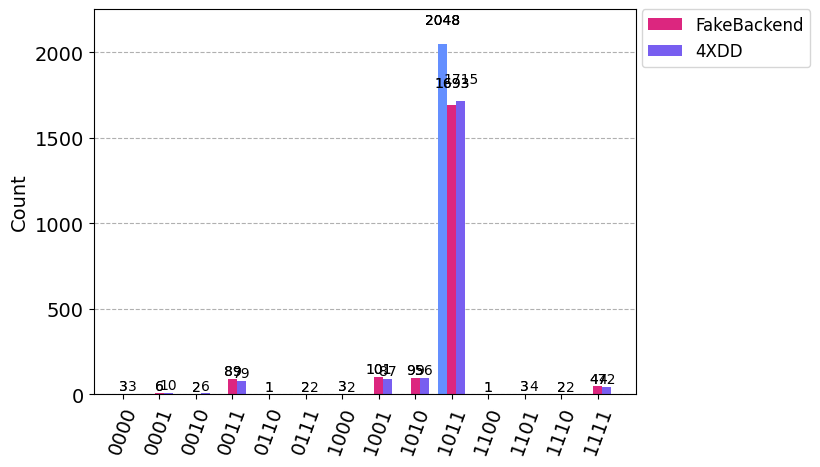

In [50]:
job_dd = backend.run(circ_dd,shots = number_of_shots )
four_x_counts = job_dd.result().get_counts()

plot_histogram([simulated_counts, backend_counts, four_x_counts], legend=['ideal', 'FakeBackend', '4XDD'])

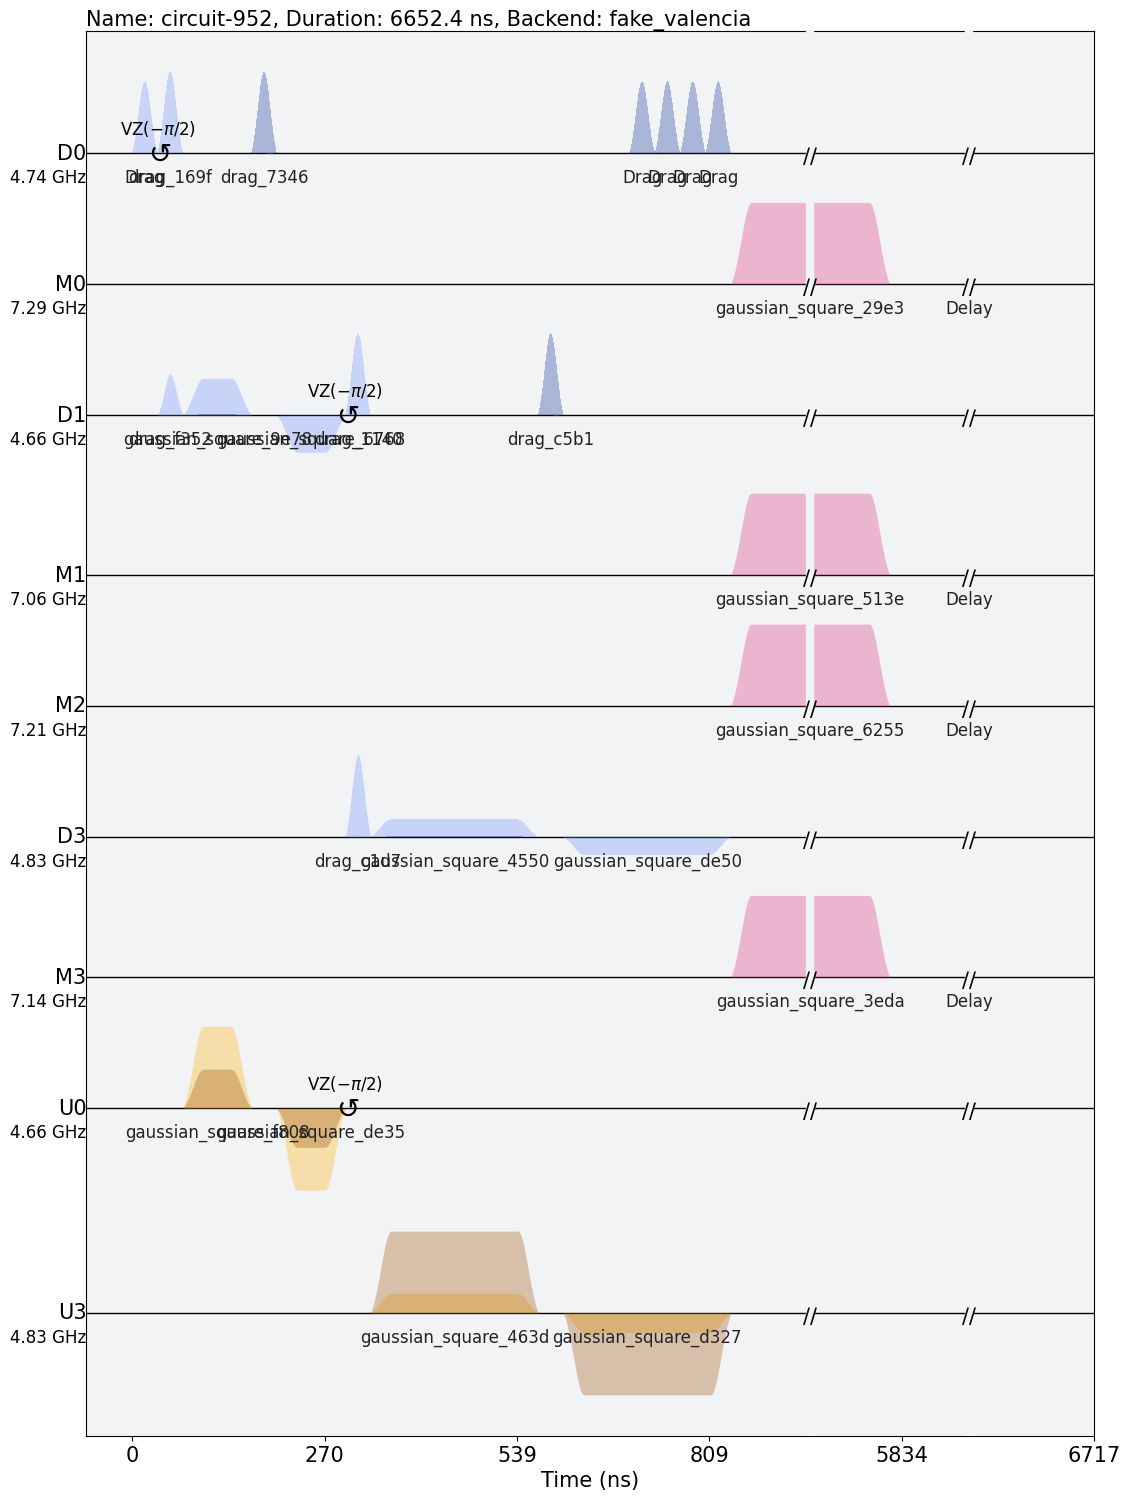

In [113]:
amp_optimal = 0.16953436127947377
with pulse.build(backend, name = 'custom_x') as my_sched:
    pulse.play(Drag(duration = 160, sigma = 40, amp = amp_optimal, beta =-0.25388969010654494 ), pulse.DriveChannel(0))
    
pulse_circuit = QuantumCircuit(4)
pulse_circuit.x(0)
pulse_circuit.cx(0,1)
pulse_circuit.cx(1,3)
pulse_circuit.x(0)
pulse_circuit.x(0)
pulse_circuit.x(0)
pulse_circuit.x(0)
pulse_circuit.measure_all()
pulse_circuit.add_calibration("x", [0], my_sched)




pulse_schedule_circuit = schedule(pulse_circuit, backend)

pulse_schedule_circuit.draw(backend=backend)

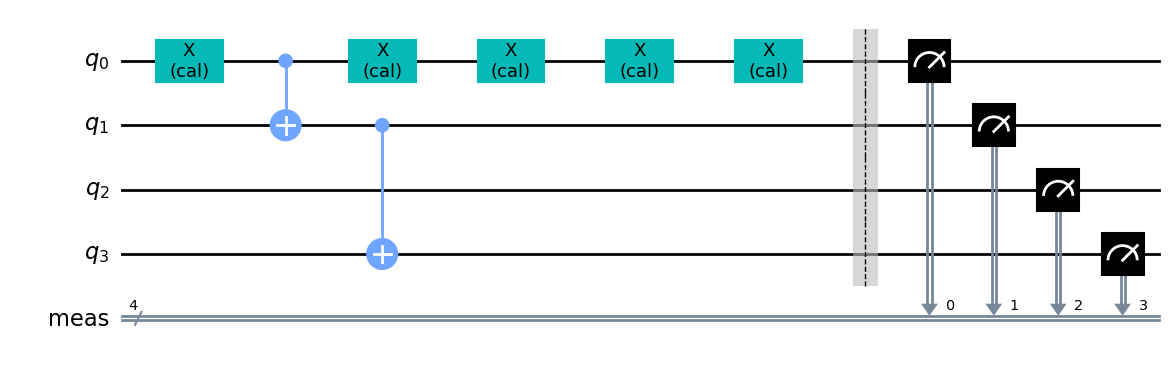

In [114]:
pulse_circuit.draw('mpl')

In [122]:
job_pulse = backend.run(pulse_circuit,shots = number_of_shots )
count_pulse = job_pulse.result().get_counts()

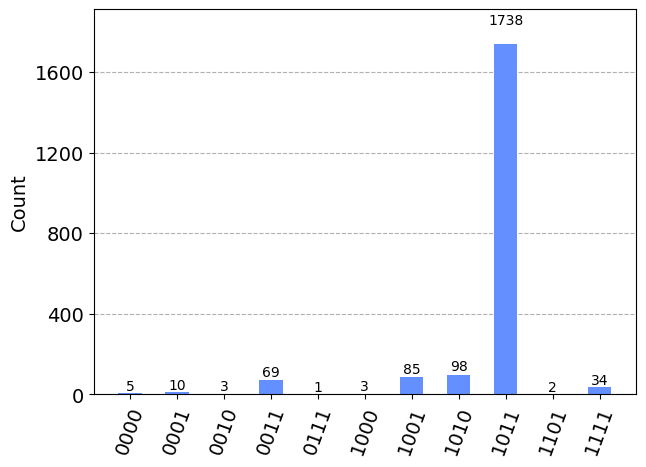

In [123]:
plot_histogram(count_pulse)

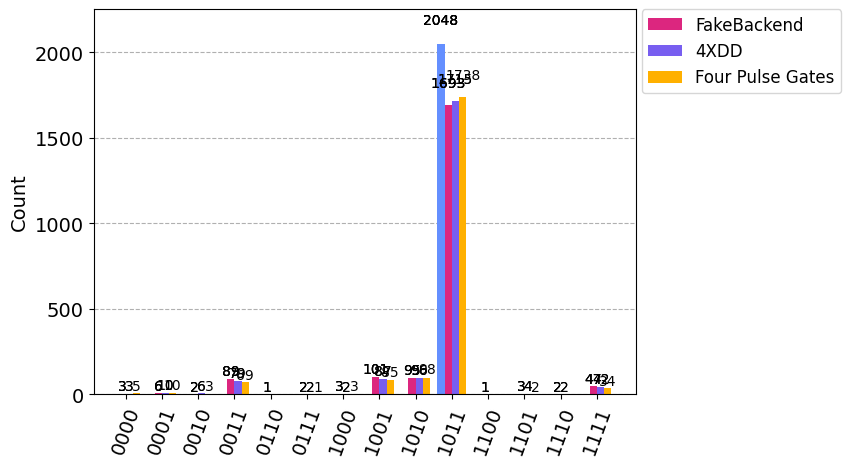

In [124]:
plot_histogram([simulated_counts, backend_counts, four_x_counts,count_pulse ], legend=['ideal', 'FakeBackend', '4XDD', 'Four Pulse Gates'])